In [ ]:
! pip install --upgrade pandas-profiling

In [12]:
import gdown

url = 'https://drive.google.com/uc?id=1UPZiTughL3iDtPwreoUs_SX-LfVktrI3'
output = 'BX-CSV-Dump.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1UPZiTughL3iDtPwreoUs_SX-LfVktrI3
To: /content/BX-CSV-Dump.zip
26.1MB [00:00, 159MB/s] 


'BX-CSV-Dump.zip'

In [ ]:
! unzip BX-CSV-Dump.zip

Archive:  BX-CSV-Dump.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Book Crossing EDA

In [388]:
import pandas_profiling
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler

sns.set()
palette = sns.color_palette("icefire")

plt.style.use('ggplot')

sns.set_context("talk")

## Loading, Cleaning and Merging the Dataset

Reading the csv files

In [259]:
users = pd.read_csv(
    '/content/BX-Users.csv', 
    names=['user_id', 'location', 'age'], 
    sep=';',
    skiprows=1,
    encoding='ISO-8859-1', 
    low_memory=False, 
    error_bad_lines=False
)
users

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


parse the datatypes properly

In [260]:
users.dtypes

user_id       int64
location     object
age         float64
dtype: object

In [261]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,278858.0,139429.500000,80499.515020,1.0,69715.25,139429.5,209143.75,278858.0
age,168096.0,34.751434,14.428097,0.0,24.00,32.0,44.00,244.0


age cannot be 244 ! so let's fix that

In [262]:
users.loc[(users.age > 100) | (users.age < 5), 'age'] = np.nan
users.age = users.age.fillna(users.age.mean())

In [263]:
users['age'] = users['age'].astype(np.uint8)

In [264]:
users['age'].describe()

count    278858.000000
mean         34.446733
std          10.551712
min           5.000000
25%          29.000000
50%          34.000000
75%          35.000000
max         100.000000
Name: age, dtype: float64

In [265]:
users.isna().sum()

user_id     0
location    0
age         0
dtype: int64

In [266]:
books = pd.read_csv(
    '/content/BX-Books.csv',
    names=['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l'], 
    sep=';',
    skiprows=1,
    encoding='ISO-8859-1', 
    low_memory=False, 
    error_bad_lines=False
)
books

,isbn,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271374,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271375,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271377,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


parse the data types properly

In [267]:
books.dtypes

isbn                   object
book_title             object
book_author            object
year_of_publication    object
publisher              object
img_s                  object
img_m                  object
img_l                  object
dtype: object

drop `['img_s', 'img_m', 'img_l']` since they are not useful for us

In [268]:
books = books.drop(['img_s', 'img_m', 'img_l'], axis=1)

`year_of_publication` should be a integer

In [269]:
books['year_of_publication'] = pd.to_numeric(books['year_of_publication'], errors='coerce')

In [270]:
books.loc[(books['year_of_publication'] == 0) | (books['year_of_publication'] > 2008), 'year_of_publication' ] = np.nan
books['year_of_publication'] = books['year_of_publication'].fillna(round(books['year_of_publication'].mean()))
books['year_of_publication'] = pd.to_numeric(books['year_of_publication'], downcast='unsigned')

In [271]:
books.isna().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
dtype: int64

In [272]:
books = books.dropna()

In [273]:
books.describe().T

,count,mean,std,min,25%,50%,75%,max
year_of_publication,271376.0,1993.692427,8.248715,1376.0,1989.0,1995.0,2000.0,2008.0


In [274]:
ratings = pd.read_csv(
    '/content/BX-Book-Ratings.csv',
    names=['user_id', 'isbn', 'book_rating'],
    sep=';',
    skiprows=1,
    encoding='ISO-8859-1', 
    low_memory=False, 
    error_bad_lines=False
)
ratings

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [275]:
ratings['book_rating'] = ratings['book_rating'].astype(np.uint8)

In [276]:
ratings.dtypes

user_id         int64
isbn           object
book_rating     uint8
dtype: object

In [277]:
ratings.isna().sum()

user_id        0
isbn           0
book_rating    0
dtype: int64

In [278]:
ratings.describe().T.astype(np.int32)

,count,mean,std,min,25%,50%,75%,max
user_id,1149780,140386,80562,2,70345,141010,211028,278854
book_rating,1149780,2,3,0,0,0,7,10


Join the three datasets based on `user_id` and `isbn`

In [279]:
temp = pd.merge(users, ratings, on='user_id')
temp = pd.merge(temp, books, on='isbn')
dataset = temp.copy()

In [280]:
dataset

,user_id,location,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher
0,2,"stockton, california, usa",18,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,8,"timmins, ontario, canada",34,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,11400,"ottawa, ontario, canada",49,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,11676,"n/a, n/a, n/a",34,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
4,41385,"sudbury, ontario, canada",34,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
...,...,...,...,...,...,...,...,...,...
1031167,278851,"dallas, texas, usa",33,0743203763,0,As Hogan Said . . . : The 389 Best Things Anyo...,Randy Voorhees,2000,Simon &amp; Schuster
1031168,278851,"dallas, texas, usa",33,0767907566,5,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001,Broadway Books
1031169,278851,"dallas, texas, usa",33,0884159221,7,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985,Lone Star Books
1031170,278851,"dallas, texas, usa",33,0912333022,7,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997,Kqed Books


Split the location into `city`, `state` and `country` and replacing missing location details with just `n/a`

In [281]:
location = dataset['location'].str.split(', ', n=2, expand=True)
location.columns = ['city', 'state', 'country']
location = location.fillna('n/a')

In [282]:
dataset['city'] = location['city'] ; dataset['state'] = location['state'] ; dataset['country'] = location['country']

In [283]:
dataset = dataset.drop(['location'], axis=1)

In [284]:
dataset.describe().T.astype(np.int32)

,count,mean,std,min,25%,50%,75%,max
user_id,1031172,140594,80524,2,70415,141210,211426,278854
age,1031172,36,10,5,31,34,41,100
book_rating,1031172,2,3,0,0,0,7,10
year_of_publication,1031172,1995,7,1376,1992,1997,2001,2008


In [285]:
dataset.isna().sum()

user_id                0
age                    0
isbn                   0
book_rating            0
book_title             0
book_author            0
year_of_publication    0
publisher              0
city                   0
state                  0
country                0
dtype: int64

In [286]:
# profile = pandas_profiling.ProfileReport(dataset)
# profile

In [287]:
dataset.shape

(1031172, 11)

In [288]:
dataset.dtypes

user_id                 int64
age                     uint8
isbn                   object
book_rating             uint8
book_title             object
book_author            object
year_of_publication    uint16
publisher              object
city                   object
state                  object
country                object
dtype: object

This will be the final dataset we will be working with !

In [289]:
dataset.head(5)

,user_id,age,isbn,book_rating,book_title,book_author,year_of_publication,publisher,city,state,country
0,2,18,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,stockton,california,usa
1,8,34,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,timmins,ontario,canada
2,11400,49,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,ottawa,ontario,canada
3,11676,34,0002005018,8,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,n/a,n/a,n/a
4,41385,34,0002005018,0,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,sudbury,ontario,canada


In [290]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031172 entries, 0 to 1031171
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   user_id              1031172 non-null  int64 
 1   age                  1031172 non-null  uint8 
 2   isbn                 1031172 non-null  object
 3   book_rating          1031172 non-null  uint8 
 4   book_title           1031172 non-null  object
 5   book_author          1031172 non-null  object
 6   year_of_publication  1031172 non-null  uint16
 7   publisher            1031172 non-null  object
 8   city                 1031172 non-null  object
 9   state                1031172 non-null  object
 10  country              1031172 non-null  object
dtypes: int64(1), object(7), uint16(1), uint8(2)
memory usage: 74.7+ MB


In [291]:
# cleaned_data = dataset.copy()

In [365]:
# dataset = cleaned_data.copy()

## Analyzing the Feature Space

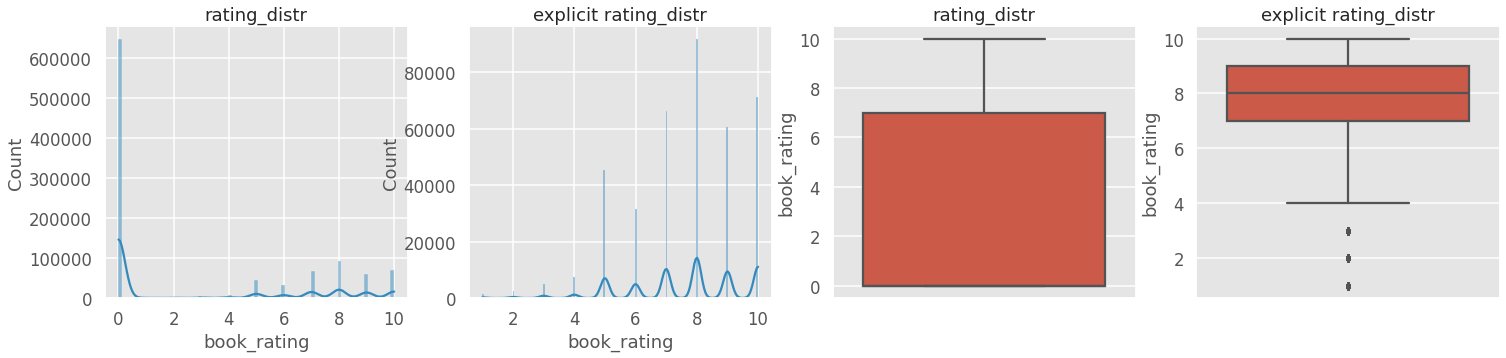

In [373]:
f, axes = plt.subplots(ncols = 4, figsize=(25, 5))
sns.histplot(x="book_rating", data=dataset, kde=True, ax=axes[0]).set_title('rating_distr')
sns.histplot(x="book_rating", data=dataset[dataset['book_rating'] != 0], kde=True, ax=axes[1]).set_title('explicit rating_distr')
sns.boxplot(y="book_rating", data=dataset, orient='v', ax=axes[2]).set_title('rating_distr')
sns.boxplot(y="book_rating", data=dataset[dataset['book_rating'] != 0], orient='v', ax=axes[3]).set_title('explicit rating_distr')
plt.show()

We can remove `0` ratings, since these are unrated, and why would someone rate a book as `0` ?

In [374]:
dataset = dataset[dataset['book_rating'] != 0]

In [450]:
def plot_univariate(dataset, column_name, suptitle = None):
    f, axes = plt.subplots(ncols = 4, figsize=(25, 5))
    sns.histplot(x=column_name, data=dataset, kde=True, ax=axes[0]).set_title(f'{column_name}_distr')
    sns.boxplot(y=column_name, data=dataset, orient='v', ax=axes[1]).set_title(f'{column_name}_box_plot')
    sns.violinplot(y=column_name, data=dataset, orient='v', ax=axes[2]).set_title(f'{column_name}_violin_plot')
    scipy.stats.probplot(dataset[column_name], dist="norm", plot=axes[3])
    if suptitle:
        plt.suptitle(suptitle)
        plt.subplots_adjust(top=0.80)
    plt.show()

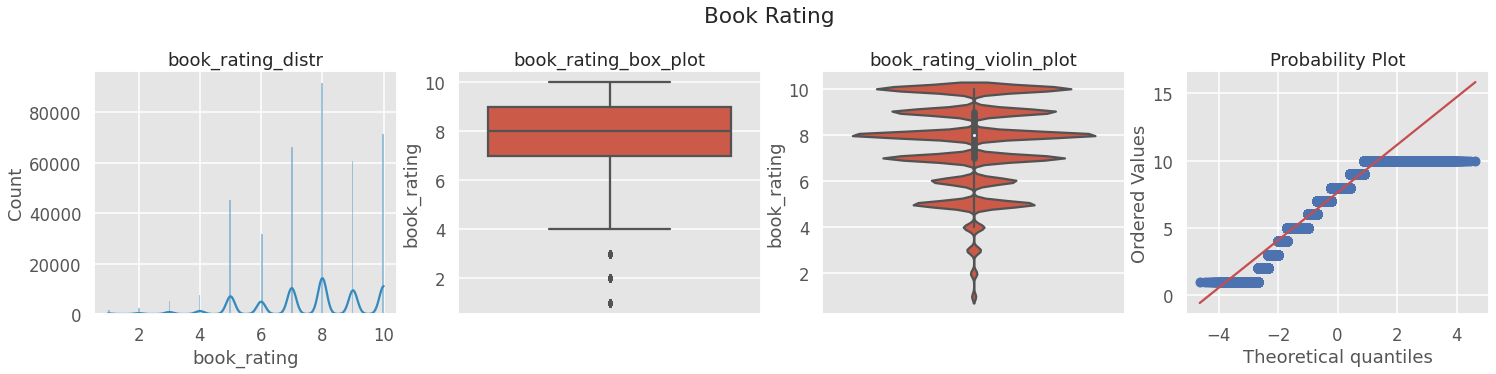

In [451]:
plot_univariate(dataset=dataset, column_name='book_rating', suptitle='Book Rating')

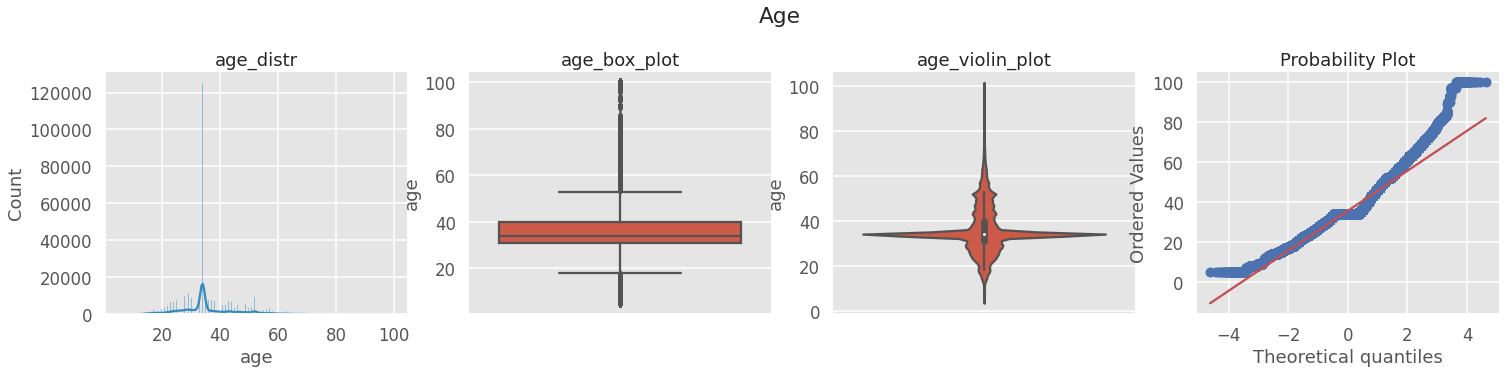

In [452]:
plot_univariate(dataset=dataset, column_name='age', suptitle='Age')

## Data Transformation

### Min-Max Normalization

$x_{scaled} = \frac{x-x_{min}}{x_{max}-x_{min}}$

In [453]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dataset['book_rating'].values.reshape(-1, 1)).reshape(-1)

In [454]:
scaled_rating = pd.DataFrame(data=scaled, columns=['book_rating'])
scaled_rating

,book_rating
0,0.444444
1,0.777778
2,0.777778
3,0.888889
4,0.888889
...,...
383844,0.666667
383845,0.444444
383846,0.666667
383847,0.666667


In [455]:
scaled_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,383849.0,0.7363,0.204593,0.0,0.666667,0.777778,0.888889,1.0


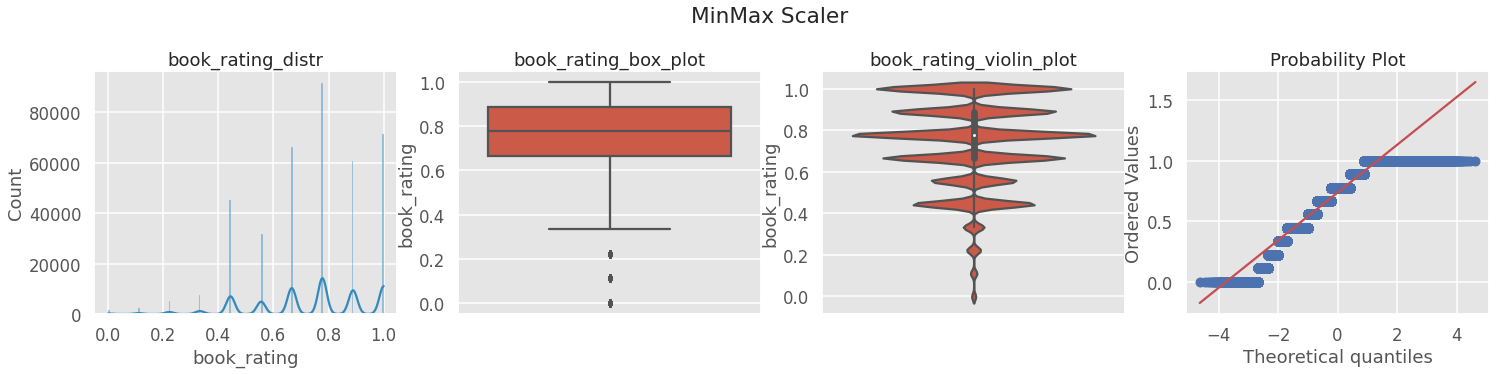

In [456]:
plot_univariate(dataset=scaled_rating, column_name='book_rating', suptitle='MinMax Scaler')

### Z-Score Standardization

$z = \frac{x-\mu}{\sigma}$

In [457]:
scaler = StandardScaler()
scaled = scaler.fit_transform(dataset['book_rating'].values.reshape(-1, 1)).reshape(-1)

In [458]:
scaled_rating = pd.DataFrame(data=scaled, columns=['book_rating'])
scaled_rating

,book_rating
0,-1.426522
1,0.202732
2,0.202732
3,0.745817
4,0.745817
...,...
383844,-0.340353
383845,-1.426522
383846,-0.340353
383847,-0.340353


In [459]:
scaled_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,383849.0,2.953229e-14,1.000001,-3.598862,-0.340353,0.202732,0.745817,1.288902


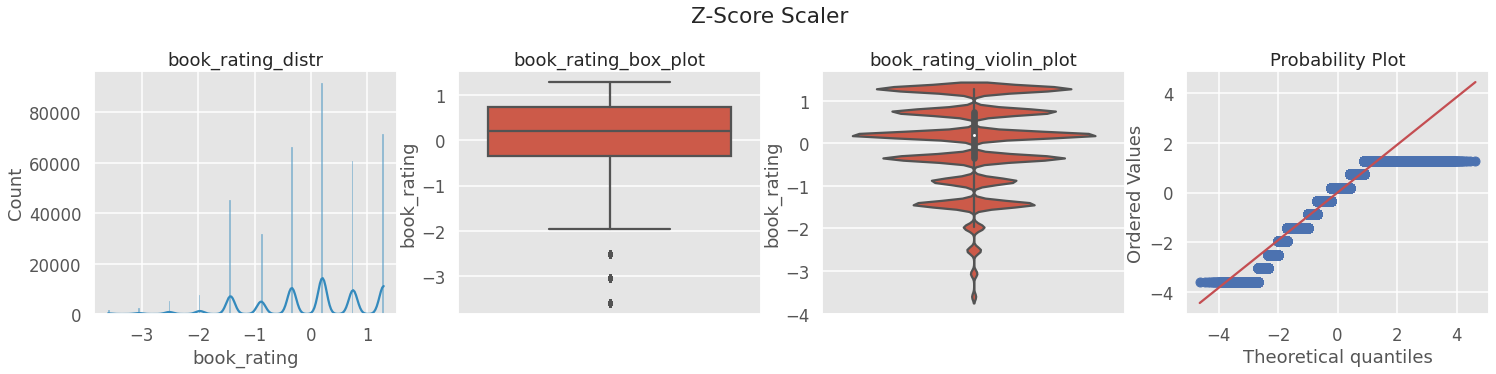

In [460]:
plot_univariate(dataset=scaled_rating, column_name='book_rating', suptitle='Z-Score Scaler')

### Decimal Scaling

$v_{i}^{'} = \frac{v_i}{10^j}$

In [461]:
p = dataset['book_rating'].max()
q = len(str(abs(p)))
scaled = dataset['book_rating'].values / 10 ** q

In [462]:
scaled_rating = pd.DataFrame(data=scaled, columns=['book_rating'])
scaled_rating

,book_rating
0,0.05
1,0.08
2,0.08
3,0.09
4,0.09
...,...
383844,0.07
383845,0.05
383846,0.07
383847,0.07


In [463]:
scaled_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,383849.0,0.076267,0.018413,0.01,0.07,0.08,0.09,0.1


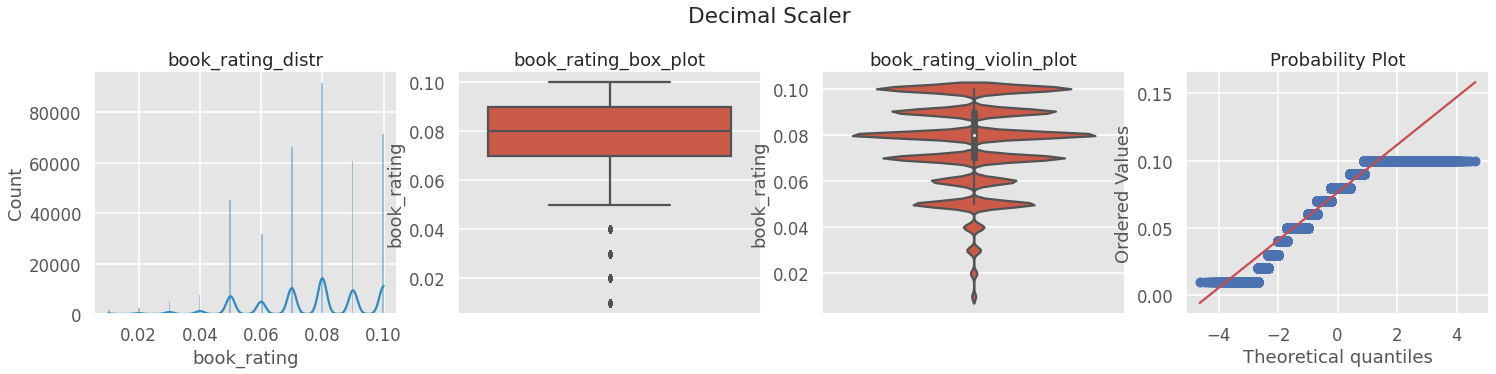

In [464]:
plot_univariate(dataset=scaled_rating, column_name='book_rating', suptitle='Decimal Scaler')

## Data Normality

### Natural Log Transform

In [465]:
transformed = np.log(dataset['book_rating'])

In [466]:
trans_rating = pd.DataFrame(data=transformed, columns=['book_rating'])
trans_rating

,book_rating
1,1.609375
3,2.080078
5,2.080078
8,2.197266
9,2.197266
...,...
1031166,1.946289
1031168,1.609375
1031169,1.946289
1031170,1.946289


In [467]:
trans_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,383849.0,NaN,0.0,0.0,1.946289,2.080078,2.197266,2.302734


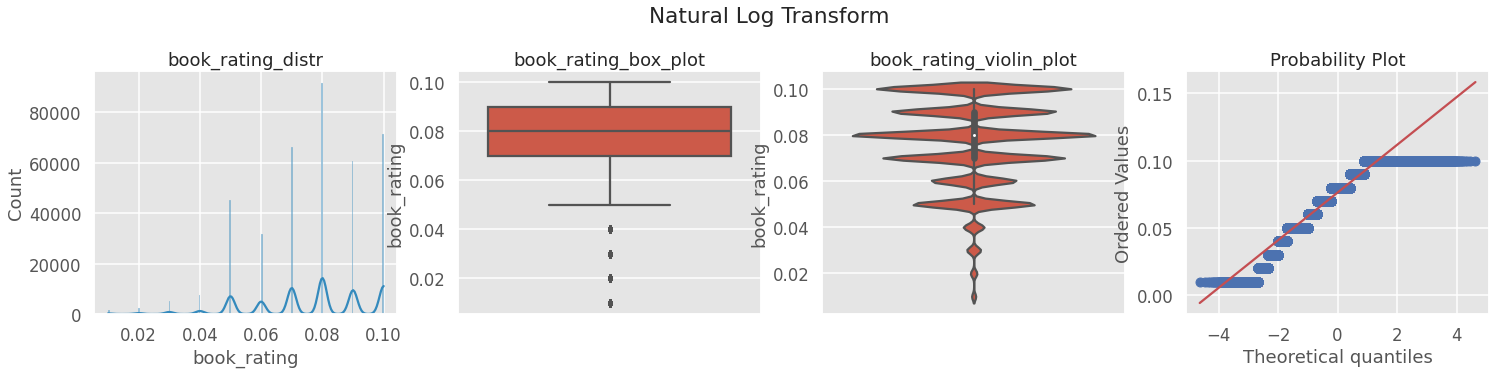

In [468]:
plot_univariate(dataset=scaled_rating, column_name='book_rating', suptitle='Natural Log Transform')

### Square Root Transform

In [469]:
transformed = np.sqrt(dataset['book_rating'])

In [470]:
trans_rating = pd.DataFrame(data=transformed, columns=['book_rating'])
trans_rating

,book_rating
1,2.236328
3,2.828125
5,2.828125
8,3.000000
9,3.000000
...,...
1031166,2.646484
1031168,2.236328
1031169,2.646484
1031170,2.646484


In [471]:
trans_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,383849.0,NaN,0.0,1.0,2.646484,2.828125,3.0,3.162109


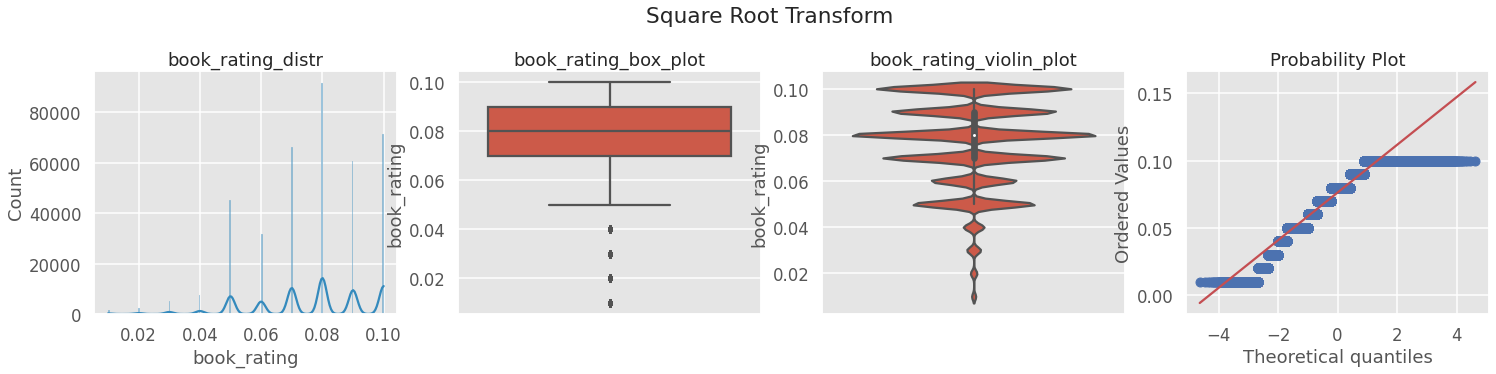

In [472]:
plot_univariate(dataset=scaled_rating, column_name='book_rating', suptitle='Square Root Transform')

## Exploratory Data Analysis

In [485]:
eda = dataset['year_of_publication'].value_counts().head(25).reset_index()
eda.columns = ['year_of_publication', 'count']

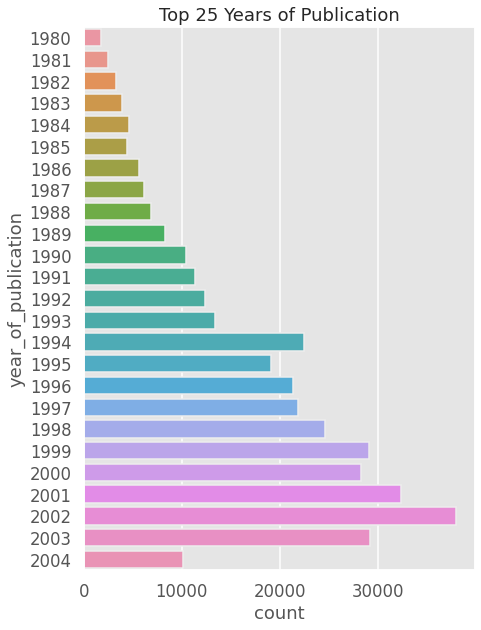

In [493]:
plt.figure(figsize=(7, 10))
sns.barplot(x='count', y='year_of_publication', data=eda, orient='h')
plt.title('Top 25 Years of Publication')
plt.show()

## Convert this Notebook to PDF

In [494]:
! apt update
! apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://archive.ubuntu.com/ubu

In [ ]:
import re, pathlib, shutil

# Get a list of all your Notebooks
notebooks = [x for x in pathlib.Path("/content/drive/My Drive/Colab Notebooks").iterdir() if 
             re.search(r"\.ipynb", x.name, flags = re.I)]

for i, n in enumerate(notebooks):
    print(f"\nProcessing  [{i+1:{len(str(len(notebooks)))}d}/{len(notebooks)}]  {n.name}\n")

    # Optionally copy your notebooks from gdrive to your vm
    shutil.copy(n, n.name)
    n = pathlib.Path(n.name)

    !jupyter nbconvert "{n.as_posix()}" --to pdf --output "{n.stem.replace(" ", "_")}"

In [495]:
import subprocess

In [ ]:
s = subprocess.Popen(shlex.split(
    f'jupyter nbconvert "{n.as_posix()}" --to pdf --output "{n.stem.replace(" ", "_")}"'
    ), shell = False, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
s.wait()
s.stdout.read()